# Visualizing Autoencoder Reconstruction Error for Anomaly Detection

## Install Dependencies

In [1]:
# Uncomment when running for the first time
# !pip install -q tfds-nightly tensorflow matplotlib
# !pip install alibi-detect

In [2]:
import glob
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
import numpy as np
from PIL import Image
import tensorflow_datasets as tfds
from alibi_detect.utils.saving import save_detector, load_detector
import matplotlib.pyplot as plt

## Load and Pre-Process Images

In [3]:
import zipfile

! wget -N https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

with zipfile.ZipFile('GTSRB_Final_Test_Images.zip', 'r') as zip_ref:
    print('Unzipping...')
    zip_ref.extractall()

! wget -N https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv

--2021-08-05 17:18:32--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘GTSRB_Final_Test_Images.zip’ not modified on server. Omitting download.

Unzipping...
--2021-08-05 17:18:36--  https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-08-05 17:18:36 

In [4]:
def get_sign_images(width, height):
    signs = []
    
    # total # of images = 12630
    for index, file in enumerate(glob.glob('GTSRB/Final_Test/Images/*ppm')):
        image = Image.open(file)
        resized_image = image.resize((width, height))
        array = np.array(resized_image)
        if index < 10000:
            signs.append(array)
        else:
            break
    
    signs = np.asarray(signs)
    signs = signs.astype("float32") / 255   
    
    return signs

In [5]:
signs_64 = get_sign_images(64, 64)

In [6]:
ds = tfds.load('cars196', split='train', as_supervised=True)
cars = []

for image, label in tfds.as_numpy(ds):
    cars.append(image)
    
cars = np.asarray(cars)

def resize(images, width, height, show_image=False):
    resized_images = []
    for image_array in images:
        image = Image.fromarray(image_array)
        if show_image:
            image.show()
        resized_image = image.resize((width, height))
        resized_image_array = np.array(resized_image)
        resized_images.append(resized_image_array)
    resized_images = np.asarray(resized_images)
    return resized_images

INFO:absl:Load dataset info from /home/ec2-user/tensorflow_datasets/cars196/2.0.1
INFO:absl:Reusing dataset cars196 (/home/ec2-user/tensorflow_datasets/cars196/2.0.1)
INFO:absl:Constructing tf.data.Dataset cars196 for split train, from /home/ec2-user/tensorflow_datasets/cars196/2.0.1
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [7]:
cars_64 = resize(cars, 64, 64)
cars_64 = cars_64.astype("float32") / 255

## Load Autoencoder and Visualize Image Reconstructions

In [8]:
od_64 = load_detector('outlier_detector_64') # Trained in a separate notebook

In [9]:
def plot_images(a, b, title_a, title_b):
    fig = plt.figure(figsize=(10, 7))
    rows, columns = 1, 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(a)
    plt.axis('off')
    plt.title(title_a)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(b)
    plt.axis('off')
    plt.title(title_b)

The outlier detector is trained on the German Traffic Sign Recognition Dataset (GTSRB). Images that belong to GTSRB should have lower reconstruction errors, and images that do not belong to GTRSB should have higher reconstruction errors. Here, we will pass an image from GTSRB through the autoencoder, and inspect its reconstruction. As expected, the reconstruction is good, so the corresponding reconstruction error is low.

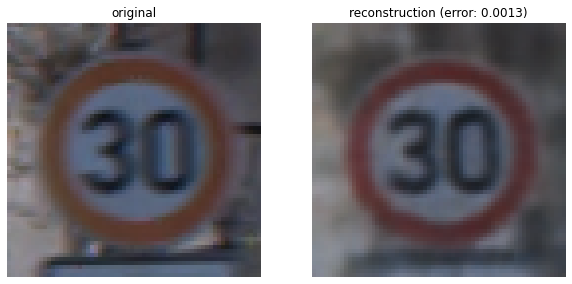

In [10]:
sign = signs_64[200]
sign_recon = od_64.ae(sign.reshape(1, 64, 64, 3))

sign_score = od_64.predict(sign.reshape(1, 64, 64, 3))["data"]["instance_score"][0]
sign_rounded_score = round(sign_score, 5)
plot_images(sign, sign_recon.numpy().reshape(64, 64, 3), "original", "reconstruction (error: " + str(sign_rounded_score) + ")")

Here, we will pass an image from the Stanford Cars dataset through the autoencoder. Since the autoencoder is trained on GTSRB, the reconstruction of a car is poor, and the corresponding reconstruction error is high.

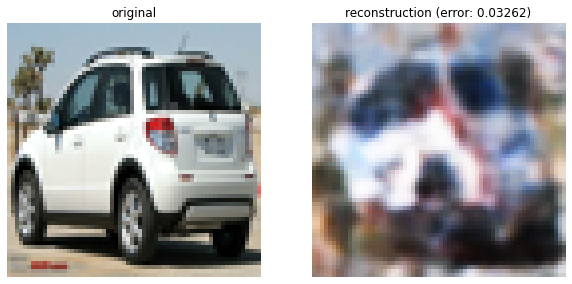

In [11]:
car = cars_64[1]
car_recon = od_64.ae(car.reshape(1, 64, 64, 3))
car_score = od_64.predict(car.reshape(1, 64, 64, 3))["data"]["instance_score"][0]
car_rounded_score = round(car_score, 5)
plot_images(car, car_recon.numpy().reshape(64, 64, 3), "original", "reconstruction (error: " + str(car_rounded_score) + ")")